The topic of colloquium is housing. 
Therefore, I conducted a test on the network of spaces, specifically libraries.

In [92]:
import geopandas as gpd
import pyogrio as ogr
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString, Point, Polygon
import pandas as pd
import requests
import networkx as nx
import osmnx as ox
import h3
import libpysal as lps

## Library in QUEENS


In [93]:
csv_file_path = 'path/to/your/file.csv'
df = pd.read_csv("Data/Queens_Libraries__Map_.csv")

In [94]:
df['Longitude'] = df['Longitude'].astype(float)
df['Latitude'] = df['Latitude'].astype(float)

In [ ]:
Queens_library = gpd.GeoDataFrame(
    Queens_library,
    geometry=gpd.points_from_xy(
        [float(x["Longitude"]) for x in Queens_library],
        [float(x["Latitude"]) for x in Queens_library],
    ),
)

## build graph to allow us to search


In [7]:
mh_bbox = Queens_library.total_bounds

In [8]:
mh_bbox

array([-73.94444 ,  40.57971 , -73.715036,  40.78864 ])

In [9]:
mh_network = ox.graph_from_bbox(
    mh_bbox[3], mh_bbox[1], mh_bbox[2], mh_bbox[0], network_type="walk"
)

C:\Users\user\AppData\Local\Temp\ipykernel_9476\307712133.py:1: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  mh_network = ox.graph_from_bbox(


In [10]:
mh_net_nodes, mh_net_edges = ox.graph_to_gdfs(mh_network)

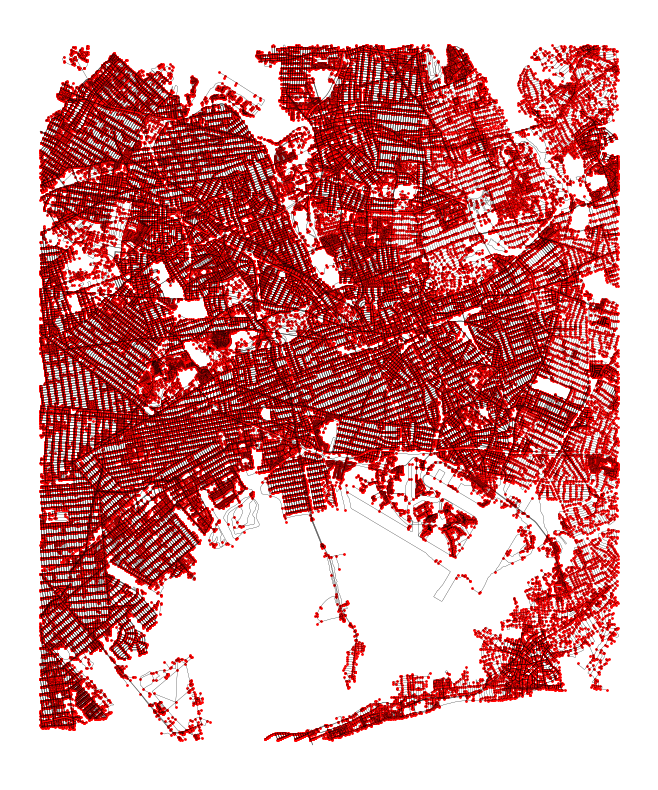

In [11]:
ax = mh_net_edges.plot(color="black", linewidth=0.1, figsize=(10, 10))
mh_net_nodes.plot(ax=ax, color="red", markersize=1).set_axis_off()

In [27]:
Queens_Aprtment = Point(-73.7614755, 40.6081037)

### get directions between virtual house in Queens and a random library using osmnx


In [28]:
# get the nearest node to avery hall
orig = ox.distance.nearest_nodes(mh_network, Queens_Aprtment.x, Queens_Aprtment.y)
sample = Queens_library.sample(1)
dest = ox.distance.nearest_nodes(mh_network, sample.geometry.x, sample.geometry.y)[0]

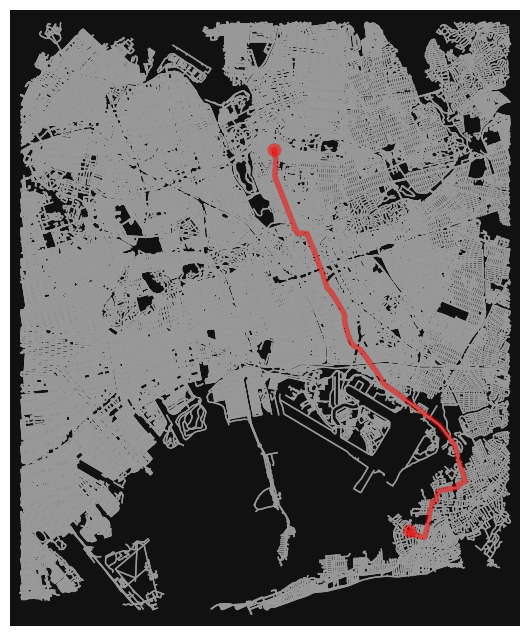

In [29]:
# find the shortest path between nodes, minimizing travel time, then plot it
route = ox.shortest_path(mh_network, orig, dest, weight="length")
fig, ax = ox.plot_graph_route(mh_network, route, node_size=0)

In [30]:
edge_lengths = ox.routing.route_to_gdf(mh_network, route)["length"]

# convert meters to miles
sum(edge_lengths) / 1609.34

12.393115811450674

<Axes: >

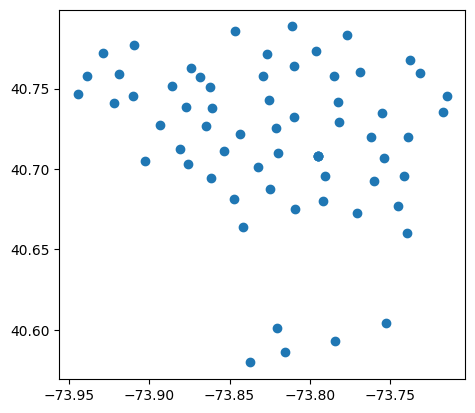

In [31]:
Queens_library.plot()

In [32]:
def distance_from_point(row, origin):
    """
    Returns the distance in miles and the geometry of the shortest path between a point and a destination.

    Parameters:
    row (pd.Series): A row from a pandas DataFrame.
    origin (int): The origin node in the network.
    """

    dest = ox.distance.nearest_nodes(mh_network, row.geometry.x, row.geometry.y)  # [0]
    route = ox.shortest_path(mh_network, origin, dest, weight="length")
    edge_lengths = ox.routing.route_to_gdf(mh_network, route)["length"]

    route_geom = ox.routing.route_to_gdf(mh_network, route)
    route_geom = route_geom.geometry.unary_union

    return {"distance": sum(edge_lengths) / 1609.34, "route_geom": route_geom}

In [43]:
Queens_library["distance_from_Queens"] = Queens_library.apply(
    distance_from_point, origin=orig, axis=1
)

In [47]:
# explode the dictionary into separate columns
Queens_library = pd.concat(
    [
        Queens_library.drop(["distance_from_Queens"], axis=1),
        Queens_library["distance_from_Queens"].apply(pd.Series),
    ],
    axis=1,
)

In [48]:
Queens_library_routes = gpd.GeoDataFrame(Queens_library, geometry="route_geom", crs="EPSG:4326")

Text(0.5, 1.0, 'Distance from Queens to \n Queens Library')

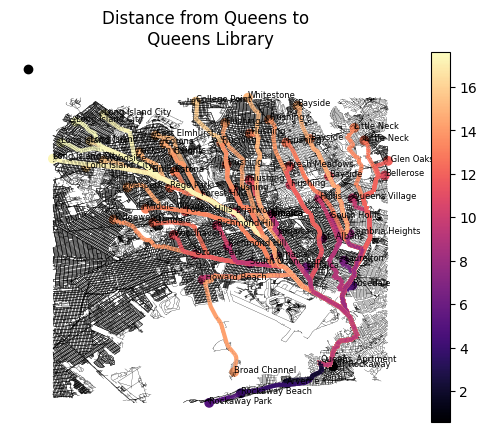

In [53]:
ax = gpd.GeoSeries(avery_hall).plot(color="black")
mh_net_edges.plot(ax=ax, color="black", linewidth=0.1)
Queens_library_routes.plot(column="distance", cmap="magma", ax=ax, linewidth=3)
Queens_library.plot(column="distance", cmap="magma", legend=True, ax=ax).set_axis_off()


# label each point
for x, y, label in zip(Queens_library.geometry.x, Queens_library.geometry.y, Queens_library.City):
    ax.text(x, y, label, fontsize=6)
ax.text(Queens_Aprtment.x, Queens_Aprtment.y, "Queens_Aprtment", fontsize=6)

# title
plt.title("Distance from Queens to \n Queens Library")

In [55]:
Queens_library[["City", "distance"]].sort_values("distance")

,City,distance
12,Far Rockaway,0.582552
64,Arverne,2.034131
56,Rockaway Beach,3.723354
46,Rockaway Park,4.992655
0,Rosedale,5.237055
...,...,...
23,Long Island City,16.412139
60,Long Island City,17.270342
28,Long Island City,17.311228
8,Long Island City,17.530389


The network and distance from a virtual home to each library demonstrate how well cultural facilities like libraries can be utilized and how effectively these libraries can be interconnected and operated.

<Axes: >

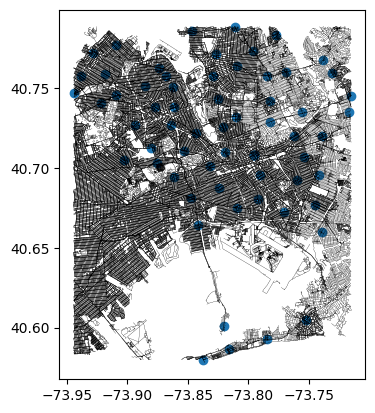

In [34]:
ax = Queens_library.plot()
mh_net_edges.plot(ax=ax, color="black", linewidth=0.1)

In [35]:
mh_net_nodes

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
42460102,40.643689,-73.890404,3,NaN,NaN,POINT (-73.89040 40.64369)
42460105,40.645062,-73.888270,3,NaN,NaN,POINT (-73.88827 40.64506)
42460121,40.635803,-73.903589,3,NaN,NaN,POINT (-73.90359 40.63580)
42460123,40.635077,-73.902781,4,NaN,NaN,POINT (-73.90278 40.63508)
42460126,40.634792,-73.902466,3,NaN,NaN,POINT (-73.90247 40.63479)
...,...,...,...,...,...,...
12083110922,40.751266,-73.836072,4,crossing,NaN,POINT (-73.83607 40.75127)
12083110930,40.752273,-73.837550,3,NaN,NaN,POINT (-73.83755 40.75227)
12083794980,40.639139,-73.741796,3,NaN,NaN,POINT (-73.74180 40.63914)


In [36]:
mh_net_nodes["h3"] = mh_net_nodes.apply(
    lambda x: h3.geo_to_h3(x.geometry.centroid.y, x.geometry.centroid.x, 9), axis=1
)

In [37]:
mh_net_nodes["h3"]

osmid
42460102       892a100cb6fffff
42460105       892a100cb6fffff
42460121       892a1076543ffff
42460123       892a1076543ffff
42460126       892a1076547ffff
                    ...       
12083110922    892a100e3c7ffff
12083110930    892a100e3c7ffff
12083794980    892a103a213ffff
12083794981    892a103a213ffff
12083794982    892a103a213ffff
Name: h3, Length: 178589, dtype: object

In [56]:
# create hexagons for AOI
mh_net_nodes["geometry"] = mh_net_nodes["h3"].apply(
    lambda x: (h3.h3_to_geo_boundary(x))
)

C:\Users\user\AppData\Local\Temp\ipykernel_9476\2385662124.py:2: UserWarning: Geometry column does not contain geometry.
  mh_net_nodes["geometry"] = mh_net_nodes["h3"].apply(


In [57]:
# flip order of coordinates for each tuple
mh_net_nodes["geometry"] = mh_net_nodes["geometry"].apply(
    lambda x: Polygon([(y, x) for x, y in x])
)

In [58]:
mh_net_nodes.crs = "EPSG:4326"

In [59]:
mh_net_nodes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [60]:
mh_net_nodes

,y,x,street_count,highway,ref,geometry,h3
osmid,,,,,,,
42460102,40.643689,-73.890404,3,NaN,NaN,"POLYGON ((-73.88984 40.64592, -73.89194 40.644...",892a100cb6fffff
42460105,40.645062,-73.888270,3,NaN,NaN,"POLYGON ((-73.88984 40.64592, -73.89194 40.644...",892a100cb6fffff
42460121,40.635803,-73.903589,3,NaN,NaN,"POLYGON ((-73.90447 40.63761, -73.90657 40.636...",892a1076543ffff
42460123,40.635077,-73.902781,4,NaN,NaN,"POLYGON ((-73.90447 40.63761, -73.90657 40.636...",892a1076543ffff
42460126,40.634792,-73.902466,3,NaN,NaN,"POLYGON ((-73.90224 40.63503, -73.90434 40.634...",892a1076547ffff
...,...,...,...,...,...,...,...
12083110922,40.751266,-73.836072,4,crossing,NaN,"POLYGON ((-73.83817 40.75294, -73.84028 40.752...",892a100e3c7ffff
12083110930,40.752273,-73.837550,3,NaN,NaN,"POLYGON ((-73.83817 40.75294, -73.84028 40.752...",892a100e3c7ffff
12083794980,40.639139,-73.741796,3,NaN,NaN,"POLYGON ((-73.74238 40.64178, -73.74448 40.640...",892a103a213ffff


In [61]:
mh_net_nodes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

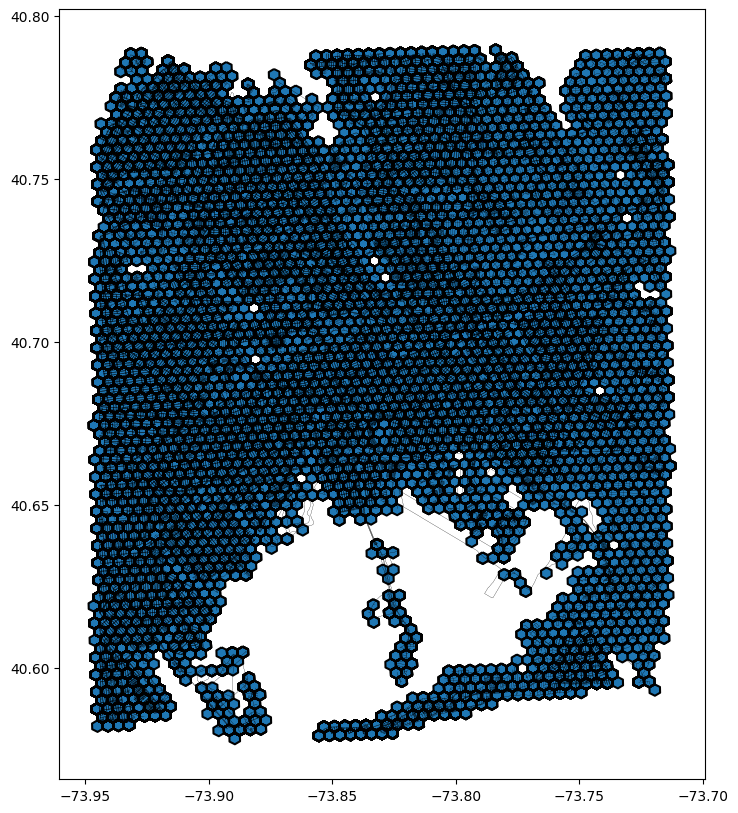

In [62]:
ax = mh_net_nodes.plot(figsize=(10, 10))
mh_net_nodes.boundary.plot(ax=ax, color="black")
mh_net_edges.plot(
    ax=ax,
    color="black",
    linewidth=0.1,
)  # .set_axis_off()

In [63]:
from lonboard import Map, PolygonLayer

In [64]:
layer = PolygonLayer.from_geopandas(
    mh_net_nodes[["geometry"]],
    get_line_color="black",
    get_fill_color="none",
    get_line_width=3,
)
# edges_layer = LineLayer.from_geopandas(
#     mh_net_edges[["geometry"]],
#     get_line_color="black",
#     get_fill_color="none",
#     get_line_width=1,
# )
m = Map(
    [
        layer,
    ]
)
m

Map(layers=[PolygonLayer(get_fill_color=(0, 0, 0, 0), get_line_color=(0, 0, 0, 255), get_line_width=3.0, table…

In [65]:
mh_net_nodes.drop_duplicates(subset="h3", inplace=True)

In [66]:
# create an adjacency matrix for the hexagons
w = lps.weights.Queen.from_dataframe(mh_net_nodes)

C:\Users\user\AppData\Local\Temp\ipykernel_9476\2435529990.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = lps.weights.Queen.from_dataframe(mh_net_nodes)
c:\Users\user\anaconda3\envs\CDP\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There is 1 island with id: 3433.
  W.__init__(self, neighbors, ids=ids, **kw)


In [67]:
# get neighbors for each hexagon
neighbors = {k: v for k, v in w.neighbors.items()}

In [68]:
neighbors

{0: [163, 164, 165, 557, 461, 558],
 1: [2, 182, 183, 11, 204, 205],
 2: [1, 3, 183, 184, 205, 206],
 3: [2, 4, 212, 184, 206, 207],
 4: [3184, 3, 212, 597, 213, 184],
 5: [178, 179, 6, 152, 153, 140],
 6: [179, 180, 5, 7, 56, 140],
 7: [180, 6, 199, 8, 56, 200],
 8: [208, 180, 596, 7, 200, 9],
 9: [208, 159, 8, 185, 10, 200],
 10: [185, 181, 9, 11, 203, 159],
 11: [1, 181, 182, 10, 203, 204],
 12: [161, 198, 345, 457, 458, 473],
 13: [258, 547, 453, 282, 3211, 14],
 14: [257, 258, 453, 205, 204, 13],
 15: [304, 16, 418, 150, 232, 303],
 16: [304, 305, 17, 232, 233, 15],
 17: [16, 305, 18, 233, 587, 542],
 18: [17, 19, 582, 570, 587, 542],
 19: [642, 18, 20, 581, 582, 542],
 20: [3074, 642, 3234, 581, 19, 525],
 21: [480, 22, 136, 124, 125, 126],
 22: [633, 21, 23, 585, 124, 125],
 23: [516, 373, 22, 585, 474, 125],
 24: [322, 323, 35, 371, 518, 25],
 25: [323, 371, 24, 26, 27, 479],
 26: [323, 324, 325, 25, 27, 28],
 27: [533, 25, 26, 28, 29, 479],
 28: [434, 435, 325, 26, 27, 29],
 2

In [69]:
# create networkx graph from adjacency matrix
G = nx.Graph(neighbors)

In [70]:
# get the path between two nodes
path = nx.shortest_path(G, 27, 18)

C:\Users\user\AppData\Local\Temp\ipykernel_9476\1576104426.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mh_net_nodes.geometry.centroid.x,
C:\Users\user\AppData\Local\Temp\ipykernel_9476\1576104426.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mh_net_nodes.geometry.centroid.y,


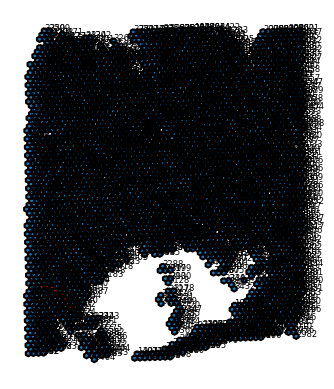

In [71]:
# plot the path
ax = mh_net_nodes.plot()
mh_net_nodes.boundary.plot(ax=ax, color="black")
mh_net_nodes.iloc[path].plot(ax=ax, color="red").set_axis_off()

# label cells with their index
for x, y, label in zip(
    mh_net_nodes.geometry.centroid.x,
    mh_net_nodes.geometry.centroid.y,
    neighbors.keys(),
):
    ax.text(x, y, label, fontsize=6)